In [1]:
import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


In [2]:
import torch
import numpy as np

env_list = [
        "button-press-topdown-v2",
        "box-close-v2",
        "dial-turn-v2",
        "sweep-v2",
        "button-press-topdown-wall-v2",
        "sweep-into-v2",
        "drawer-open-v2",
        "lever-pull-v2",
]

pair_algo_list = [
    "ternary-500-aug-10000-conf-0.999",
    "ternary-500-aug-10000-bucket-20-uncert-3.1",
    "ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1",
]

exp_name = "CUDA-01-00"
pair_algo = "ternary-500"
reward_model_algo = "MR-linear"


os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

TRAJECTORY_LENGTH = 25

In [3]:
policy_rate_dict = {
    "button-press-topdown-v2": {
        "ternary-500-aug-10000-conf-0.999": 0.4920,
        "ternary-500-aug-10000-bucket-20-uncert-3.1": 0.6018,
    },
    "box-close-v2": {
        "ternary-500-aug-10000-conf-0.999": 0.6004,
        "ternary-500-aug-10000-bucket-20-uncert-3.1": 0.6220,
    },
    "drawer-open-v2": {
        "ternary-500-aug-10000-conf-0.999": 0.0280,
        "ternary-500-aug-10000-bucket-20-uncert-3.1": 0.0560,
    },
    "sweep-into-v2": {
        "ternary-500-aug-10000-conf-0.999": 0.2300,
        "ternary-500-aug-10000-bucket-20-uncert-3.1": 0.3488,
    },
    "lever-pull-v2": {
        "ternary-500-aug-10000-conf-0.999": 0.6764,
        "ternary-500-aug-10000-bucket-20-uncert-3.1": 0.8608,
    },
}

In [4]:
from data_generation.data_research import predict_rewards
from data_loading.load_data import load_dataset


def predict_only_rewards(
    env_name,
    exp_name,
    pair_algo,
    reward_model_algo,
):
    result = predict_rewards(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_algo,
        reward_model_algo=reward_model_algo,
    )

    pred_reward_list = [r for (_, r, _, _) in result]
    pred_reward_list = np.array(pred_reward_list)

    return pred_reward_list


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_total_reward(s, e, reward_cumsum):
    return reward_cumsum[e - 1] - (reward_cumsum[s - 1] if s > 0 else 0)

In [5]:
from data_loading.load_data import load_pair

In [6]:
def plot_feedback_heatmap_minimal(
    feedbacks,
    env_name,
    test_pair_algo,
    unlabel_pair="unlabel-100000"
):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(figsize=(5.5, 5))

    dataset = load_dataset(env_name=env_name)
    cumsum = np.cumsum(dataset["rewards"], dtype=np.float64)

    unlabel_pairs = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="train",
        pair_algo=unlabel_pair,
    )
    raw_traj_truth_rewards = [
        get_total_reward(s, e, cumsum)
        for (s, e), _, _ in unlabel_pairs
    ] + [
        get_total_reward(s, e, cumsum)
        for _, (s, e), _ in unlabel_pairs
    ]

    traj_truth_rewards = []
    for (s0, e0), (s1, e1), mu in feedbacks:
        r0 = get_total_reward(s0, e0, cumsum)
        r1 = get_total_reward(s1, e1, cumsum)
        traj_truth_rewards.append((r0, r1))
        traj_truth_rewards.append((r1, r0))

    bins = 25
    bin_edges = np.linspace(0, 250, bins + 1)
    r0_list = [r0 for r0, _ in traj_truth_rewards]
    r1_list = [r1 for _, r1 in traj_truth_rewards]
    observed, _, _ = np.histogram2d(r0_list, r1_list, bins=[bin_edges, bin_edges])
    observed = observed.T
    traj_hist, _ = np.histogram(raw_traj_truth_rewards, bins=bin_edges)
    traj_prob = traj_hist / np.sum(traj_hist)
    expected = np.outer(traj_prob, traj_prob) * np.sum(observed)
    ratio = observed / (expected + 1e-8)
    adjusted_ratio = np.power(ratio, 0.3)

    ax.imshow(
        adjusted_ratio,
        origin="lower",
        aspect="equal",
        extent=[0, 250, 0, 250],
        cmap="Blues",
        vmin=0.6,
        vmax=1.4
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")

    plt.show()

In [7]:
from data_loading.load_data import load_pair

def sum_pairs(
    env,
    pair_algo,
):
    for i in range(10):
        exp_name = f"CUDA-01-{i:02d}"
        pairs = load_pair(
            env_name=env,
            exp_name=exp_name,
            pair_type="train",
            pair_algo=pair_algo,
        ).tolist()
        if i == 0:
            all_pairs = pairs
        else:
            all_pairs += pairs
        
    return all_pairs


def main():
    for env in env_list:
        for pair_algo in pair_algo_list:
            print(f"env: {env}, pair_algo: {pair_algo}")
            feedbacks = sum_pairs(env, pair_algo)
            plot_feedback_heatmap_minimal(
                feedbacks,
                env,
                pair_algo,
                unlabel_pair="unlabel-100000"
            )
    
    

env: button-press-topdown-v2, pair_algo: ternary-500-aug-10000-conf-0.999


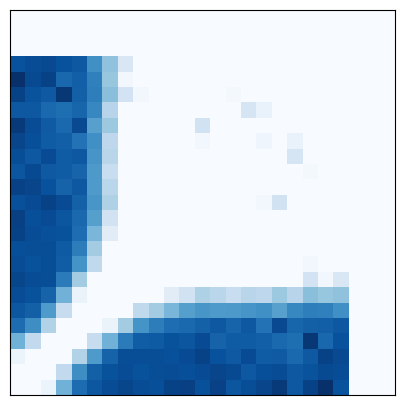

env: button-press-topdown-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


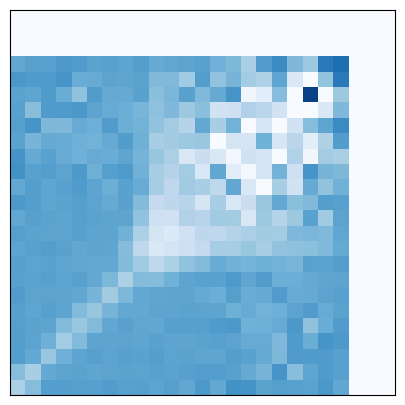

env: button-press-topdown-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


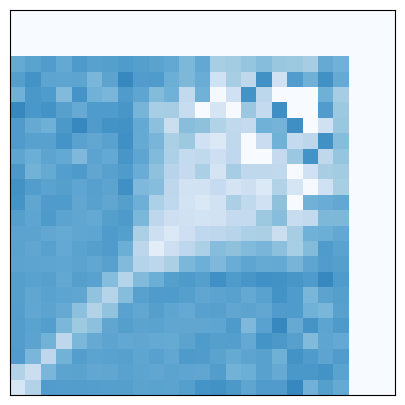

env: box-close-v2, pair_algo: ternary-500-aug-10000-conf-0.999


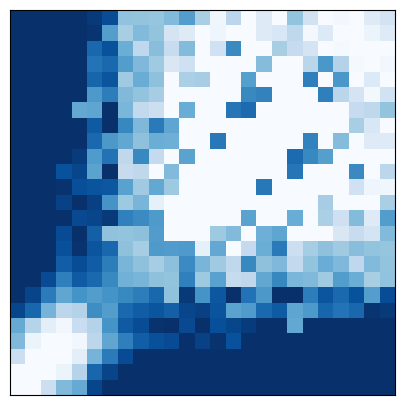

env: box-close-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


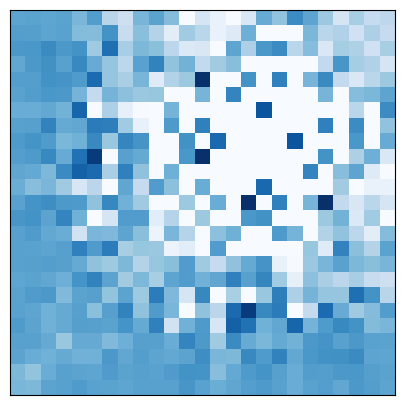

env: box-close-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


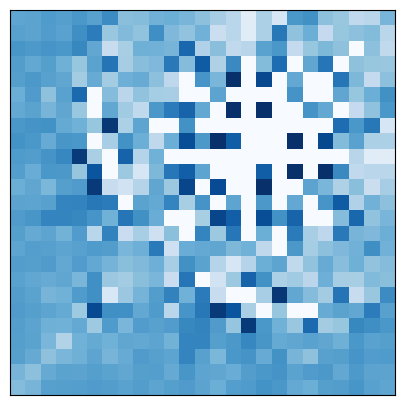

env: dial-turn-v2, pair_algo: ternary-500-aug-10000-conf-0.999


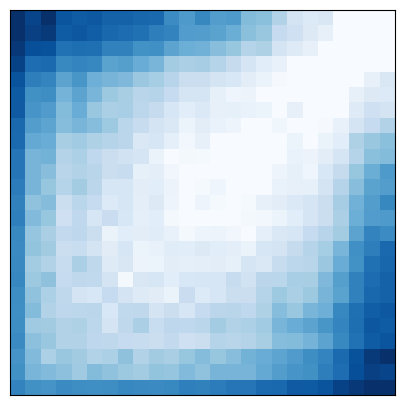

env: dial-turn-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


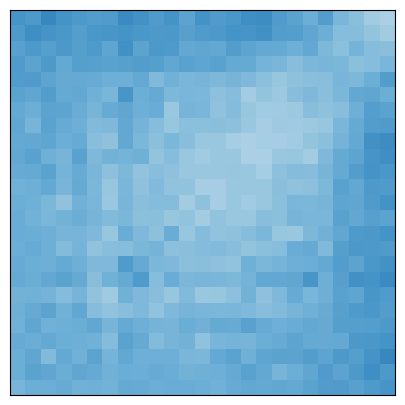

env: dial-turn-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


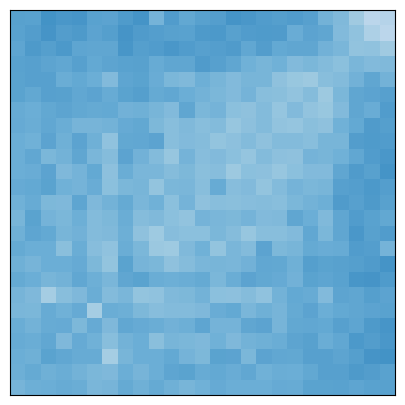

env: sweep-v2, pair_algo: ternary-500-aug-10000-conf-0.999


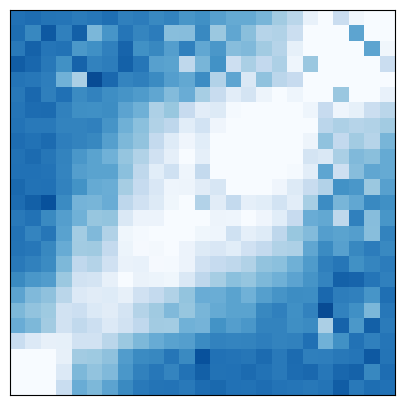

env: sweep-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


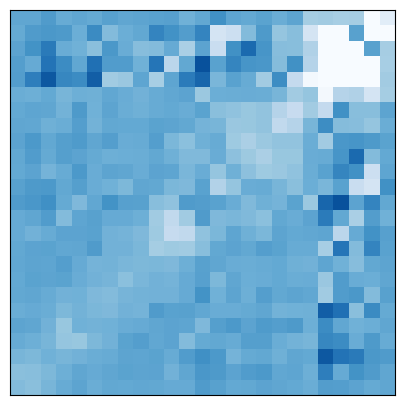

env: sweep-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


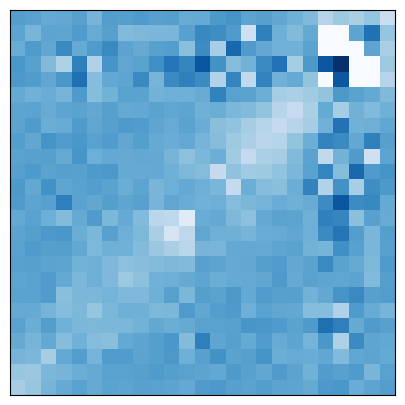

env: button-press-topdown-wall-v2, pair_algo: ternary-500-aug-10000-conf-0.999


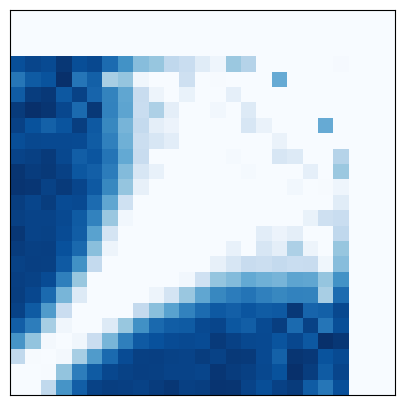

env: button-press-topdown-wall-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


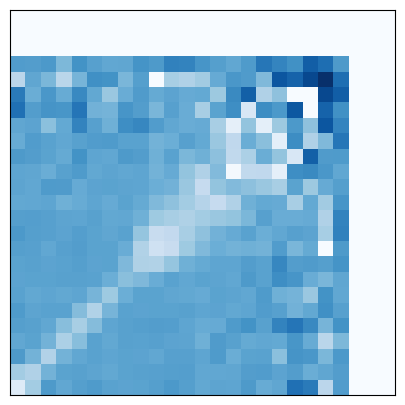

env: button-press-topdown-wall-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


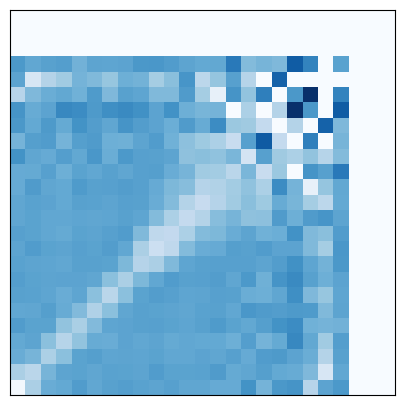

env: sweep-into-v2, pair_algo: ternary-500-aug-10000-conf-0.999


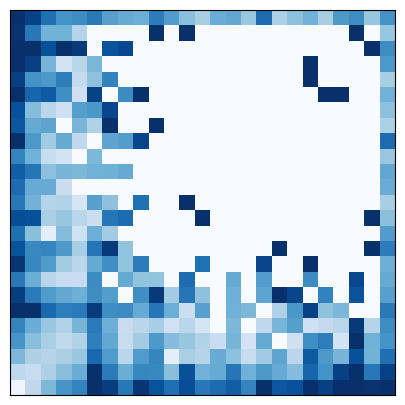

env: sweep-into-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


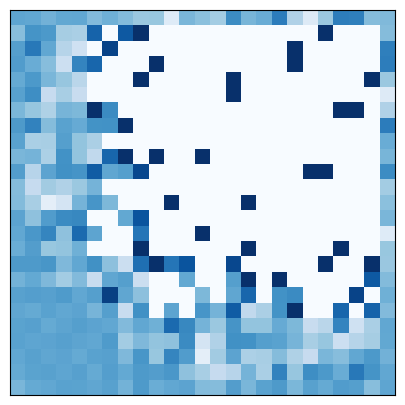

env: sweep-into-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


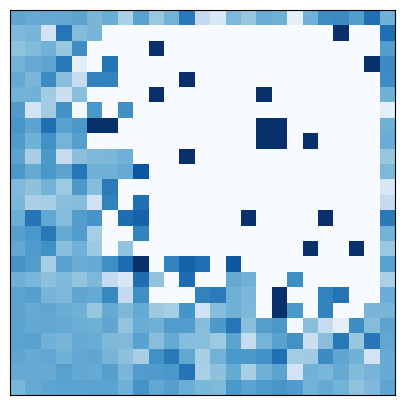

env: drawer-open-v2, pair_algo: ternary-500-aug-10000-conf-0.999


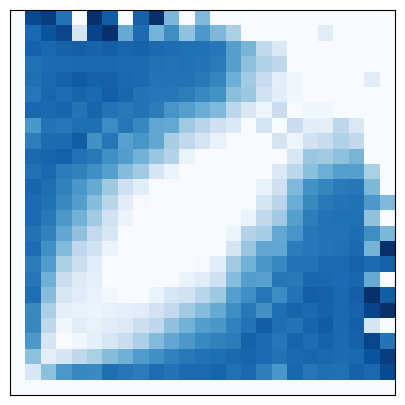

env: drawer-open-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


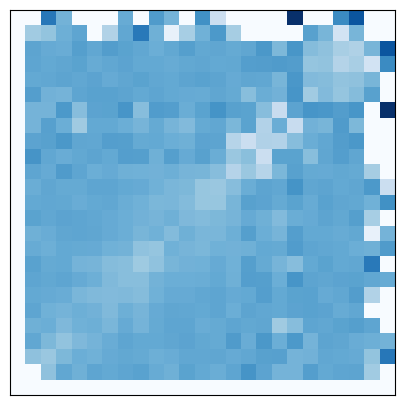

env: drawer-open-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


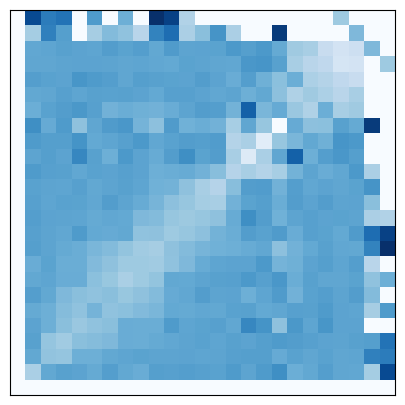

env: lever-pull-v2, pair_algo: ternary-500-aug-10000-conf-0.999


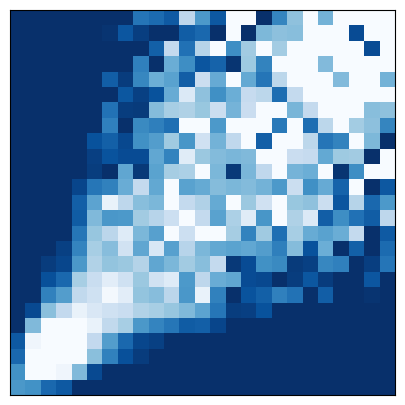

env: lever-pull-v2, pair_algo: ternary-500-aug-10000-bucket-20-uncert-3.1


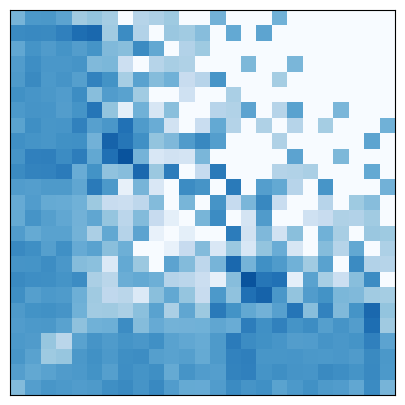

env: lever-pull-v2, pair_algo: ternary-500-aug-10000-bucket-knn-ratio-10-20-uncert-3.1


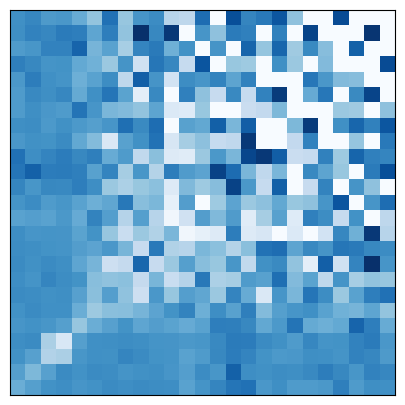

In [8]:
main()